In [1]:
import torch as t
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from periodic_padding import periodic_padding
from hamiltonian_diff import model
from cell_typing import CellKind, CellMap

In [2]:
t.device("cuda")

device(type='cuda')

In [3]:
class STETest(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input == 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [4]:
def bg_contacts(conv_mat:t.Tensor) -> t.Tensor:
    num_convs = conv_mat.shape[1]
    return t.sum((1 - conv_mat) * conv_mat[:,:,4].T.expand(num_convs, 9))

In [5]:
def unfold_conv(batch: t.Tensor) -> t.Tensor:
    unfold_transform = t.nn.Unfold(kernel_size=3)
    # provide a periodic torus padding to the grid
    padded_batch = periodic_padding(batch)
    # we need to add a channel dimension because unfold expects vectors of shape (N,C,H,W)
    padded_batch = padded_batch.unsqueeze(1)
    # apply the unfolding operator on the padded grid, this provides all convolution blocks
    unfolded_batch = unfold_transform(padded_batch)
    # turn each convolution block into a row
    batch_reshaped = unfolded_batch.permute(0, 2, 1)
    return batch_reshaped

In [25]:
def grid2gsc(grid, scale_min, scale_max):
    mask = t.logical_and(grid != 0, grid != 1)
    print(mask)
    p_vec = grid[mask].unsqueeze(1)
    p_vec_expanded = t.cat((1-p_vec, p_vec), dim=1)
    print(p_vec_expanded)
    gumbel_samples = t.nn.functional.gumbel_softmax(t.special.logit(p_vec_expanded), tau=1.0, hard=True)
    print(gumbel_samples)
    cell_ids = 1 - gumbel_samples[:, 0]
    reconstruction = t.zeros(*grid.shape, device="cuda")
    reconstruction[t.logical_not(mask)] += grid[t.logical_not(mask)]
    reconstruction[mask] += cell_ids
    reconstruction *= scale_max
    reconstruction[reconstruction == 0] += scale_min
    return reconstruction

In [35]:
def reconstruction_loss(ref_pic, rec_pic):
    return t.log(t.sum((ref_pic - rec_pic)**2))

In [62]:
def loss_fn(grid, ref_pic):
    conv_mat = unfold_conv(grid)
    rec_pic = grid2gsc(grid, scale_min=0, scale_max=50)
    return bg_contacts(conv_mat)*10 + reconstruction_loss(ref_pic, rec_pic)

In [63]:
input_state = t.load("input_pic.pt")

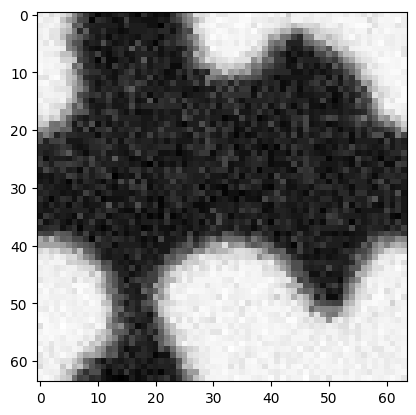

In [64]:
plt.imshow(input_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

In [65]:
threshold = 25

grid = input_state[0].detach().clone()
grid[grid < 25] = 0
grid[grid >= 25] = 1
grid = grid.unsqueeze(0)

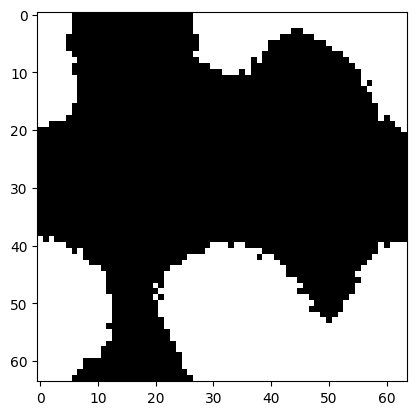

In [66]:
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [67]:
test_grid = grid.detach().clone()

In [68]:
test_grid.requires_grad_()
loss = loss_fn(test_grid, input_state)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)


In [69]:
loss

tensor(6655.6289, device='cuda:0', grad_fn=<AddBackward0>)

In [70]:
t.autograd.grad(loss, test_grid)

(tensor([[[89.9993, 89.9993, 89.9992,  ..., 89.9992, 89.9993, 89.9993],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9994,  ..., 89.9992, 89.9992, 89.9993],
          ...,
          [89.9991, 89.9993, 89.9993,  ..., 89.9992, 89.9993, 89.9992],
          [89.9993, 89.9993, 89.9993,  ..., 89.9993, 89.9993, 89.9993],
          [89.9993, 89.9994, 89.9994,  ..., 89.9993, 89.9993, 89.9993]]],
        device='cuda:0'),)

In [74]:
for i in range(1000):
    loss = loss_fn(test_grid, input_state)
    grads = t.autograd.grad(loss, test_grid)[0]
    test_grid = t.clamp(test_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)


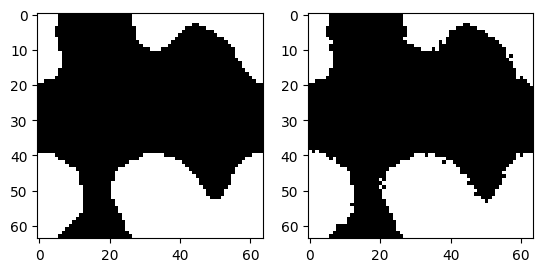

In [75]:
opt_grid = grid2gsc(test_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

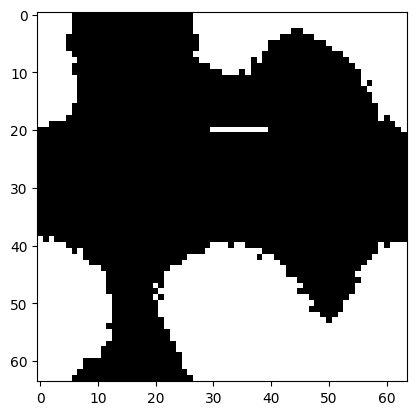

In [78]:
test2 = grid.detach().clone()
test2[0,20,30:40] = 0
plt.imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [80]:
train_test2 = test2.detach().clone()
train_test2.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0', requires_grad=True)

In [81]:
for i in range(1000):
    loss = loss_fn(train_test2, input_state)
    grads = t.autograd.grad(loss, train_test2)[0]
    train_test2 = t.clamp(train_test2 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)


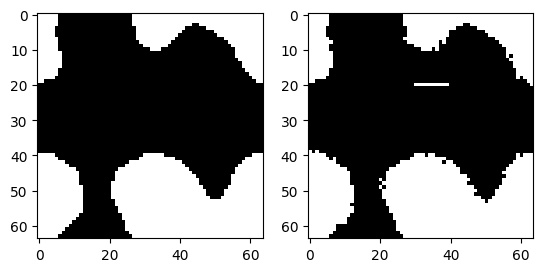

In [82]:
opt_grid = grid2gsc(train_test2, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[0].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].imshow(test2[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [83]:
test3 = test2.detach().clone()
test3[0,20:25,10:20] = 0

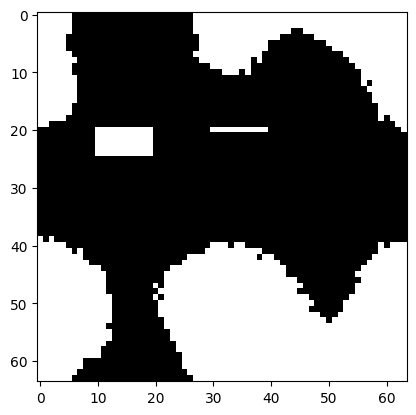

In [84]:
plt.imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [85]:
train_test3 = test3.detach().clone()
train_test3.requires_grad_()

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0', requires_grad=True)

In [86]:
for i in range(1000):
    loss = loss_fn(train_test3, input_state)
    grads = t.autograd.grad(loss, train_test3)[0]
    train_test3 = t.clamp(train_test3 - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([[0.0100, 0.9900],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.0300, 0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

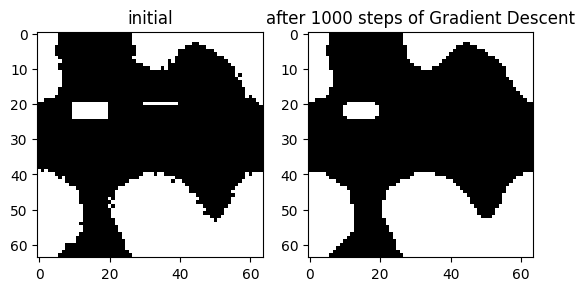

In [90]:
opt_grid = grid2gsc(train_test3, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(test3[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")

In [92]:
input_state_ref = input_state[0].detach().clone().unsqueeze(0)
input_state_ref[0,20,30:40] = 0
input_state_ref[0,20:25,10:20] = 0

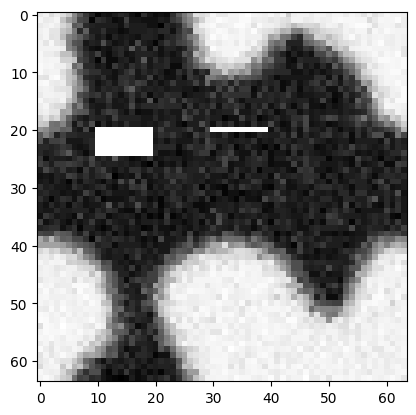

In [94]:
plt.imshow(input_state_ref[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)

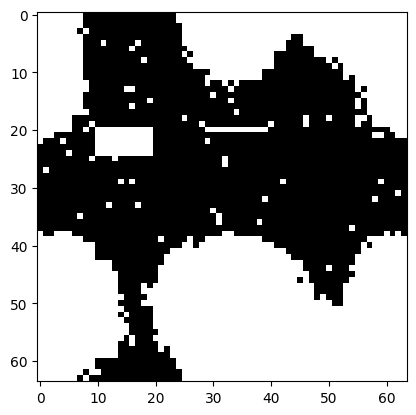

In [101]:
threshold = 40

grid = input_state[0].detach().clone()
grid[grid < threshold] = 0
grid[grid >= threshold] = 1
grid = grid.unsqueeze(0)
grid[0,20,30:40] = 0
grid[0,20:25,10:20] = 0
plt.imshow(grid[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=1)

In [102]:
ex_3_grid = grid.detach().clone()
ex_3_grid.requires_grad_()
for i in range(1000):
    loss = loss_fn(ex_3_grid, input_state)
    grads = t.autograd.grad(loss, ex_3_grid)[0]
    ex_3_grid = t.clamp(ex_3_grid - 0.001 * grads, min=0, max=1)

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([[0.0300, 0.9700],
        [0.9700, 0.0300],
        [0.0100, 0.9900],
        [0.9300, 0

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 2), grad_fn=<CatBackward0>)
tensor([], device='cuda:0', size=(0, 2), grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'initial')

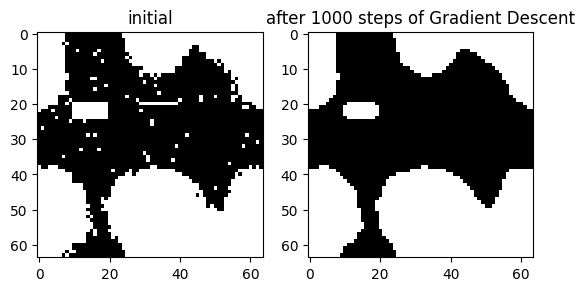

In [103]:
opt_grid = grid2gsc(ex_3_grid, scale_min=0, scale_max=50)
fig, axs = plt.subplots(1,2)

axs[1].imshow(opt_grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("after 1000 steps of Gradient Descent")
axs[0].imshow(grid[0].detach().cpu().numpy(), cmap="Greys",interpolation="nearest",vmin=0,vmax=1)
axs[0].set_title("initial")